In [271]:
# Import all necessary packages
import numpy as np
from scipy.special import gamma
import scipy.integrate as integrate
import matplotlib.pyplot as plt

from tick.base import TimeFunction
from tick.hawkes import SimuInhomogeneousPoisson
import pdb

In [379]:
# Parameters for arrival processes
numPatients = 100 # Input roughly the scale of the incident. I.e. how many patients do you expect?
peakR = 2.5 # This parameter controls when the peak of arrivals is for red patients
peakG = 1.5 # This parameter controls when the peak of arrivals is for green patients
ratio = 1/3 # Ratio of red patients to green patients

# Compute parameters for functions
cG = numPatients / (1+ratio)
cR = numPatients - cG

In [380]:
# Define patient arrival rate function
def lam(time, c, a):
    t = time/60
    out = c / 60 * (t)**(a-1)*np.exp(-t)/(gamma(a))
    return out


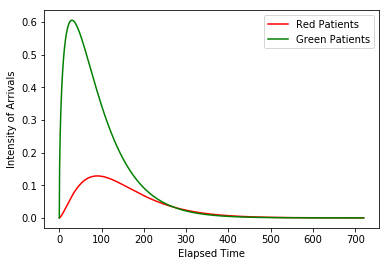

In [381]:
# Lets plot the arrival rate functions for both classes of patients
tp = np.linspace(0, 720, num = 1000)
plt.plot(tp, lam(tp, cR, peakR), label='Red Patients', color='red') # First plot for red patients
plt.plot(tp, lam(tp, cG, peakG), label='Green Patients', color='green') # First plot for green patients
plt.xlabel('Elapsed Time')
plt.ylabel('Intensity of Arrivals')
plt.legend()
plt.show() 

In [382]:
# Parameters of survival probabilities
initR = .51 # Initial survival probability for red
initG = .81 # Initial survival probability for green
platR = 91 # Legnth of plateau for red
platG = 160 # Legnth of plateau for green
decR = 1.58 # Rate of decay for red
decG = 2.41 # Rate of decay for green

In [383]:
# Parameters of survival probabilities
def survival(time, b0, b1, b2):
    t = time
    out = b0 / ((t/b1)**b2 + 1)
    return out

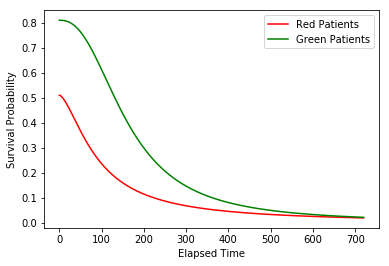

In [384]:
tp = np.linspace(0, 720, num = 1000)
plt.plot(tp, survival(tp, initR, platR, decR), label='Red Patients', color='red') # First plot for red patients
plt.plot(tp, survival(tp, initG, platG, decG), label='Green Patients', color='green') # First plot for red patients
plt.xlabel('Elapsed Time')
plt.ylabel('Survival Probability')
plt.legend()
plt.show() 

In [375]:
# Run simulation
def simulate(reps, numBeds, divTime, policy):
    if policy == 'Optimal':
        value, action = back_it_opt(dt, 720, numBeds, divTime, lam)
    tp = np.linspace(0, 720, num = 1000)
    yr = lam(tp, cR, peakR)
    yg = lam(tp, cG, peakG)
    tfr = TimeFunction((tp, yr))
    tfg = TimeFunction((tp, yg))
    died = np.zeros(reps)
    survived = np.zeros(reps)
    final_beds = np.zeros(reps)


    for i in range(reps): 
        ppr = SimuInhomogeneousPoisson([tfr], end_time=720, verbose=False)
        ppg = SimuInhomogeneousPoisson([tfg], end_time=720, verbose=False)
        ppr.simulate()
        ppg.simulate()
        timesR = ppr.timestamps[0]
        timesG = ppg.timestamps[0]
        total_patients = len(timesR) + len(timesG)
        bedsRemaining = numBeds
        while len(timesR) > 0 and len(timesG) >0:
    #         pdb.set_trace()
            t = np.minimum(timesR[0], timesG[0])
            if t == timesR[0]:
                timesR = timesR[1:]
                is_red = 1
            else:
                timesG = timesG[1:]
                is_red = 0
            if policy == 'FCFS':
                if bedsRemaining > 0:
                    admit = 1
                else:
                    admit = 0
            elif policy == 'Red Only':
                if bedsRemaining > 0 and is_red == 1:
                    admit = 1
                else:
                    admit = 0
            elif policy == 'Green Only':
                if bedsRemaining > 0 and is_red == 0:
                    admit = 1
                else:
                    admit = 0
            elif policy == 'Optimal':
                if is_red == 1:
                    admit = action[bedsRemaining, int(np.round(t/dt)), 0]
                else:
                    admit = action[bedsRemaining, int(np.round(t/dt)), 1]

            if admit == 1:
                bedsRemaining += -1
                if is_red == 1:
                    survived[i] += np.random.binomial(1, survival(t, initR, platR, decR))
                else:
                    survived[i] += np.random.binomial(1, survival(t, initG, platG, decG))
            else:
                if is_red == 1:
                    survived[i] += np.random.binomial(1, survival(t+divTime, initR, platR, decR))
                else:
                    survived[i] += np.random.binomial(1, survival(t+divTime, initG, platG, decG))

        died[i] = total_patients - survived[i]
        final_beds[i] = bedsRemaining
    print(np.mean(died))
    print(np.mean(survived))
    print(np.mean(final_beds))
#     plt.hist(survived)
        

In [376]:
# Near-Optimal Solution
del_t = 1
T = 720
def back_it_opt(dt, T, tot_beds, delay, lam):
    num_tp = int(np.ceil(T/dt)+1)
    value = np.zeros((tot_beds+1, num_tp+1, 3))
    action = np.zeros((tot_beds+1, num_tp+1, 3))
    def lam_tot(t):
        return lam(t, cR, peakR)+lam(t, cR, peakR)
    for i in range(num_tp-1, -1, -1):
        lamr = lam(i*dt, cR, peakR)
        lamg = lam(i*dt, cG, peakG)
        for j in range(1, tot_beds+1):
            for m in range(3):
                if m == 0:
                    temp_val_admit = survival(i*dt, initR, platR, decR)
                    temp_val_reject = survival(i*dt + delay, initR, platR, decR)
                elif m == 1:
                    temp_val_admit = survival(i*dt, initG, platG, decG)
                    temp_val_reject = survival(i*dt + delay, initG, platG, decG)
                else:
                    temp_val_admit = 0
                    temp_val_reject = 0
             
                integ = (1-np.exp(-integrate.quad(lam_tot, i*dt, (i+1)*dt)[0]))
#                 pdb.set_trace()
                if (lamg+lamr) >0:
                    pmtr = lamr/(lamg+lamr)*integ
                    pmtg = lamg/(lamg+lamr)*integ
                else:
                    pmtr = 0
                    pmtg = 0
                if m == 2:
                    action[j, i, m] = 0
                    value[j, i, m] = (pmtr*value[j, i+1, 0] + pmtg*value[j, i+1, 1] 
                                    + (1-pmtg-pmtr)*value[j, i+1, 2])
                else:    
                    temp_val_reject += (pmtr*value[j, i+1, 0] + pmtg*value[j, i+1, 1] 
                                        + (1-pmtg-pmtr)*value[j, i+1, 2])
                    temp_val_admit += (pmtr*value[j-1, i+1, 0] + pmtg*value[j-1, i+1, 1]
                                       + (1-pmtg-pmtr)*value[j-1, i+1, 2])
                    if temp_val_reject >= temp_val_admit:
                        value[j, i, m] = temp_val_reject
                        action[j, i, m] = 0
                    else:
                        value[j, i, m] = temp_val_admit
                        action[j, i, m] = 1
        print('Generating optimal policy is ' + str(np.round(100 - i/num_tp*100,1)) + '% complete!', end="\r")
    print('Generating optimal policy is 100% complete!')
    return value, action
                    
        



In [377]:
# Simulation Parameters
reps = 1000
numBeds = 10
divTime = 100
dt = .1
simulate(reps, numBeds, divTime, 'Optimal')
simulate(reps, numBeds, divTime, 'FCFS')
simulate(reps, numBeds, divTime, 'Red Only')
# simulate(reps, numBeds, divTime, 'Green Only')

Generating optimal policy is 100% complete!e!
83.476
16.449
1.194
83.667
16.311
0.0
84.124
15.905
0.0


1000

1.08